In [130]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split

In [131]:
columns    = ["gamma_PT","piminus_PT","piminus_IP_OWNPV","Kplus_IP_OWNPV","Kplus_PT","Kst_892_0_PT","Kst_892_0_IP_OWNPV","B_MINIPCHI2","B_FD_OWNPV","B_Cone3_B_ptasy","nTracks"]
modes      = ["kpi","kpisw", "pipi"]
hist_style = {"bins" : 100, "density" : True, "alpha" : 1, "histtype" : "step"}
colors     = {"kpi" : "#066bd6", "kpisw"  : "#d60645",  "pipi" : "#2fad66", "ratio":"#000000"}

In [132]:
dataframes  = {}
path = "/Users/finnjohnonori/Documents/GitHubRepositories/HistogramsLHCbFull/data/"

# Imports the Kpi monte carlo data - Original
with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as Kpi_TChain_MC_up: # type: ignore
    Kpi_TTree_up         = Kpi_TChain_MC_up["DecayTree"]
    Kpi_up_MC_df         = Kpi_TTree_up.arrays(columns, library="pd") # type: ignore

with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as Kpi_TChain_MC_down: # type: ignore
    Kpi_TTree_MC_down    = Kpi_TChain_MC_down["DecayTree"]
    Kpi_down_MC_df       = Kpi_TTree_MC_down.arrays(columns, library="pd") # type: ignore

dataframes["kpi"]   = pd.concat((Kpi_up_MC_df, Kpi_down_MC_df))

# Import the pipi monte carlo data
# with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as pipi_TChain_MC_up: # type: ignore
#     pipi_TTree_MC_up     = pipi_TChain_MC_up["DecayTree"]
#     pipi_up_MC_df        = pipi_TTree_MC_up.arrays(self.columns, library="pd") # type: ignore

# with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as pipi_TChain_MC_down: # type: ignore
#     pipi_TTree_MC_down   = pipi_TChain_MC_down["DecayTree"]
#     pipi_down_MC_df      = pipi_TTree_MC_down.arrays(self.columns, library="pd") # type: ignore

# self.dataframes["pipi"]  = pd.concat((pipi_up_MC_df, pipi_down_MC_df))

#Imports the Sample Data - Target
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM         = Kpi_TChain_SM["DecayTree"]

dataframes["kpisw"] = Kpi_TTree_SM.arrays(columns + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)") # type: ignore
dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)

print("Data has been loaded")

Data has been loaded


In [133]:
# divide original samples into training ant test parts
kpiMC_train, kpiMC_test = train_test_split(dataframes["kpi"])
# divide target samples into training ant test parts
kpiSW_train, kpiSW_test = train_test_split(dataframes["kpisw"])

kpiMC_weights_train  = np.ones(len(kpiMC_train))
kpiMC_weights_test   = np.ones(len(kpiMC_test))

kpiSW_weights_train  = kpiSW_train["NB0_Kpigamma_sw"]
kpiSW_weights_test   = kpiSW_test["NB0_Kpigamma_sw"]
print("Data has been Split")

Data has been Split


In [134]:
StandardReweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
StandardReweighter.fit(kpiMC_train, kpiSW_train[columns], original_weight=kpiMC_weights_train , target_weight=kpiSW_weights_train)
print("Standard Reweighter Created")

MemoryError: Unable to allocate 1.46 PiB for an array with shape (20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20) and data type float64

In [135]:
GradientBoostedReweighter = reweight.GBReweighter(n_estimators=250, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, gb_args={'subsample': 0.4})
GradientBoostedReweighter.fit(kpiMC_train, kpiSW_train[columns])
print("Gradient Boosted Reweighter Created")

Gradient Boosted Reweighter Created


In [136]:

def CreateDoublePlot(variable, Reweighter):

    #Create First Two Plots
    canvas, ((dist_original, dist_trained),(rati_original, rati_trained) ) = plt.subplots(2,2, gridspec_kw={"height_ratios" : [2,1] },figsize=(15, 7))
    canvas.suptitle(f"{variable} reweighting")
    canvas.tight_layout()

    rati_original.grid(axis="both", linestyle="dashed", alpha=0.5)
    dist_original.grid(axis="both", linestyle="dashed", alpha=0.5)
    rati_trained. grid(axis="both", linestyle="dashed", alpha=0.5)
    dist_trained. grid(axis="both", linestyle="dashed", alpha=0.5)

    KS_before = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=kpiMC_weights_test, weights2=np.ones(len(kpiSW_test[variable]), dtype=float))
    dist_original.set_title("Before KS: " + str(np.round(KS_before,4)))


    xLowerBound = min(list(kpiMC_test[variable]) + list(kpiSW_test[variable]))
    xUpperBound = max(list(kpiMC_test[variable]) + list(kpiSW_test[variable]))

    

    #Create First Plot
    hist_kpi_y,   hist_kpi_x,   _  = dist_original.hist(kpiMC_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpi"  ], label="kpi MC",     **hist_style)
    hist_kpisw_y, hist_kpisw_x, _  = dist_original.hist(kpiSW_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpisw"], label="Kpi Sample", **hist_style)
    
    rati_original.set_yscale("log")

    ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
    rati_original.scatter(hist_kpisw_x[:-1], ratio_data, s=5, c=colors["ratio"])

    FittedWeights = Reweighter.predict_weights(kpiMC_test)

    KS_After = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=FittedWeights, weights2=np.ones(len(kpiSW_test[variable]), dtype=float))
    dist_trained.set_title("After KS: " + str(np.round(KS_After,4)))

    #Create Second Plot
    hist_trained_kpi_y,   hist_kpi_x,   _  = dist_trained.hist(kpiMC_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpi"  ], weights=FittedWeights, label="kpi MC",  **hist_style)
    hist_trained_kpisw_y, hist_kpisw_x, _  = dist_trained.hist(kpiSW_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpisw"], label="Kpi Sample", **hist_style)
    
    ydistUpperBound = max(list(hist_kpisw_y) + list(hist_kpi_y) + list(hist_trained_kpi_y) + list(hist_trained_kpisw_y) )*1.1

    dist_trained.legend()

    ratio_data_trained = np.nan_to_num( (hist_trained_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)

    rati_trained.scatter(hist_kpisw_x[:-1],ratio_data_trained, s=5, c=colors["ratio"])
    rati_trained.grid(axis="both", linestyle="dashed", alpha=0.7)
    dist_trained.grid(axis="both", linestyle="dashed", alpha=0.7)

    rati_trained.set_yscale("log")

    dist_original.set_ylim(0, ydistUpperBound)
    dist_trained.set_ylim(0,  ydistUpperBound)

    r = list(ratio_data) + list(ratio_data_trained)
    rati_original.set_ylim(0.1, 5)
    rati_trained.set_ylim(0.1, 5)

    rati_original.set_xlim(xLowerBound, xUpperBound)
    dist_original.set_xlim(xLowerBound, xUpperBound)
    rati_trained.set_xlim(xLowerBound, xUpperBound)
    dist_trained.set_xlim(xLowerBound, xUpperBound)

    dist_trained.xaxis.set_tick_params(which = "both", labelbottom=False, bottom=False)
    dist_trained.yaxis.set_tick_params(which = "both", labelleft=False, left=False)
    dist_original.xaxis.set_tick_params(which = "both",labelbottom=False, bottom=False)
    rati_trained.yaxis.set_tick_params(which = "both", labelleft=False, left=False)

    #Display the final images
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.02, 
                    hspace=0.0)
    
    plt.savefig(f"{variable}_GBReWeight.png")

/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_74368/4252914333.py:28: RuntimeWarning: divide by zero encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_74368/4252914333.py:28: RuntimeWarning: invalid value encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_74368/4252914333.py:44: RuntimeWarning: divide by zero encountered in divide
  ratio_data_trained = np.nan_to_num( (hist_trained_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_74368/4252914333.py:44: RuntimeWarning: invalid value encountered in divide
  ratio_data_trained = np.nan_to_num( (hist_trained_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)


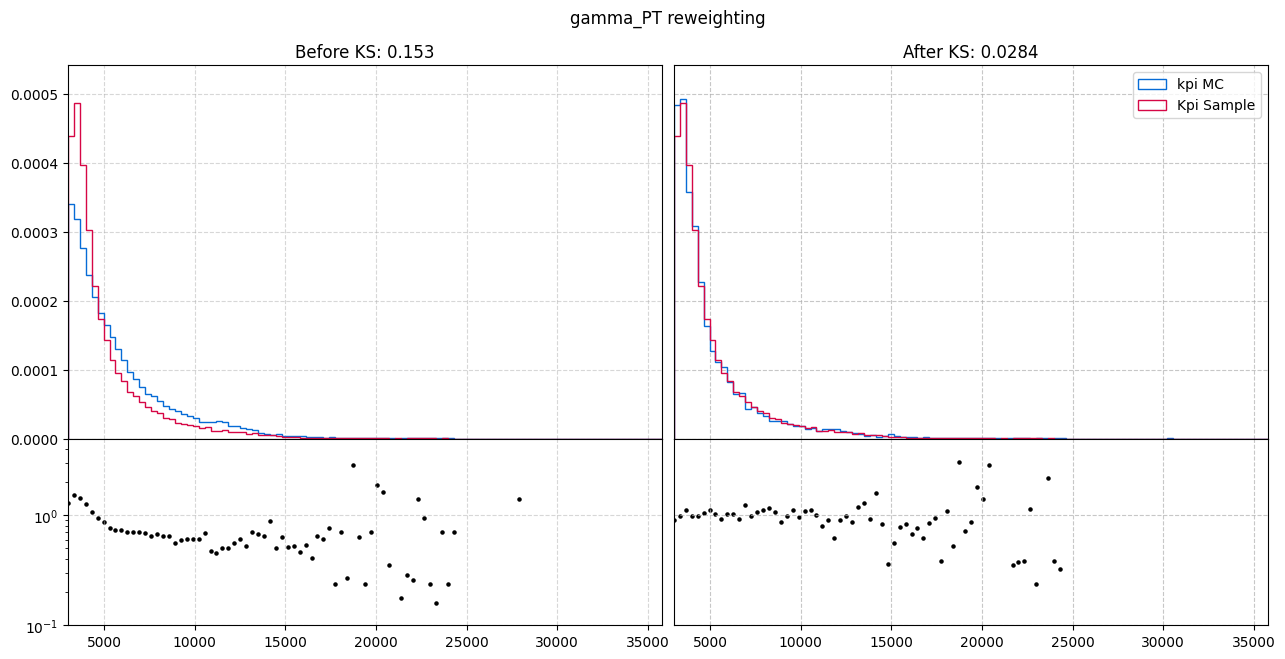

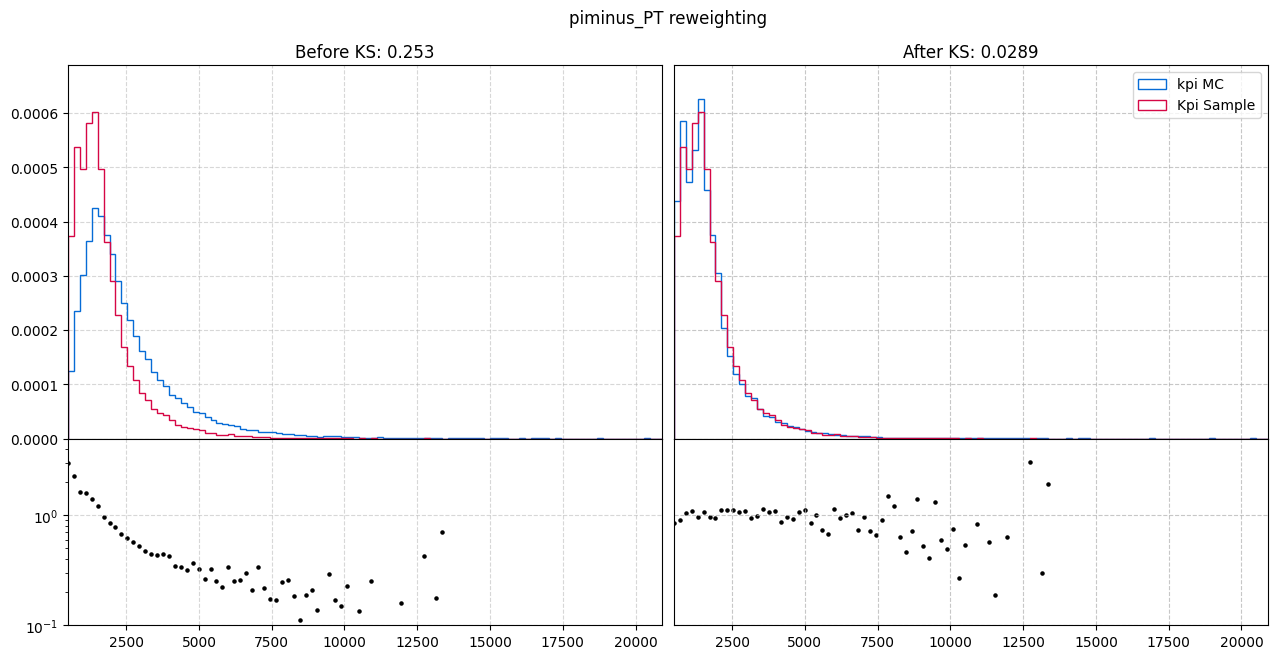

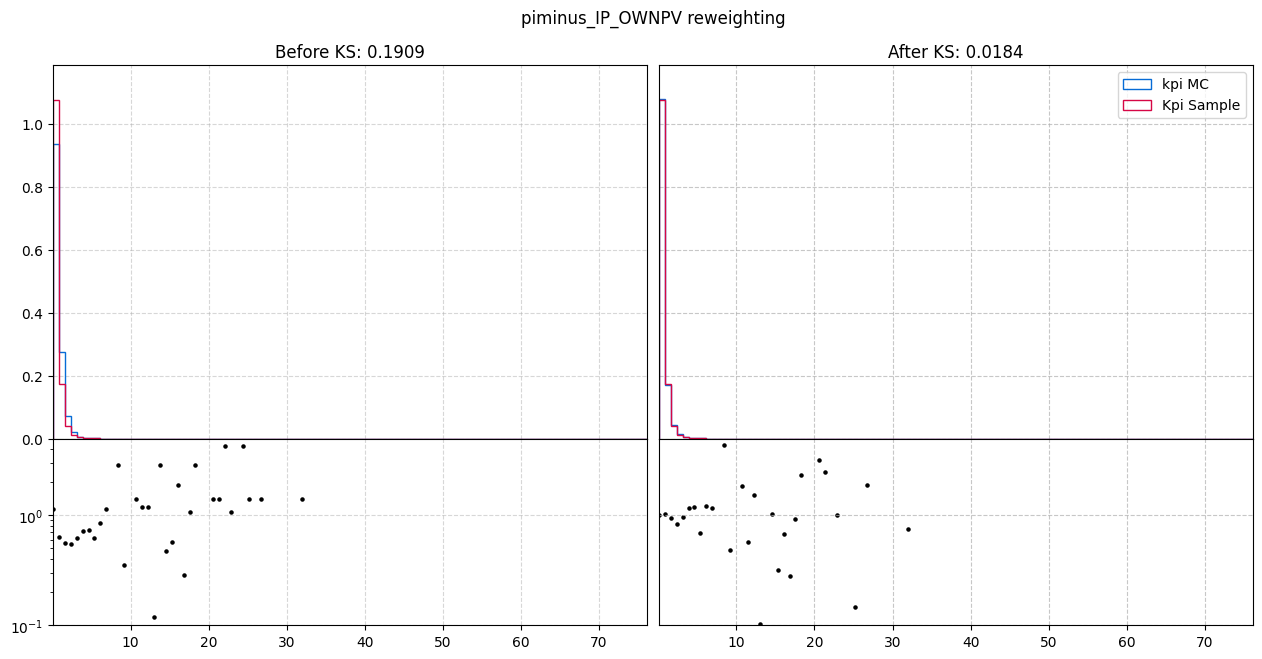

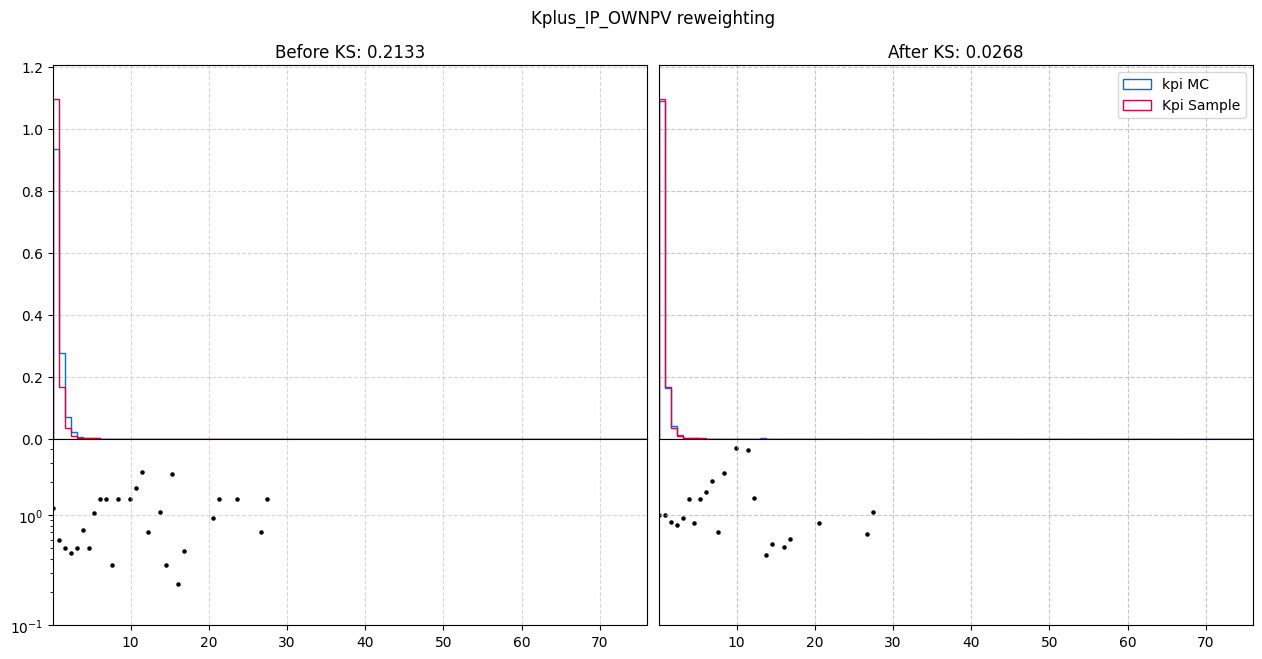

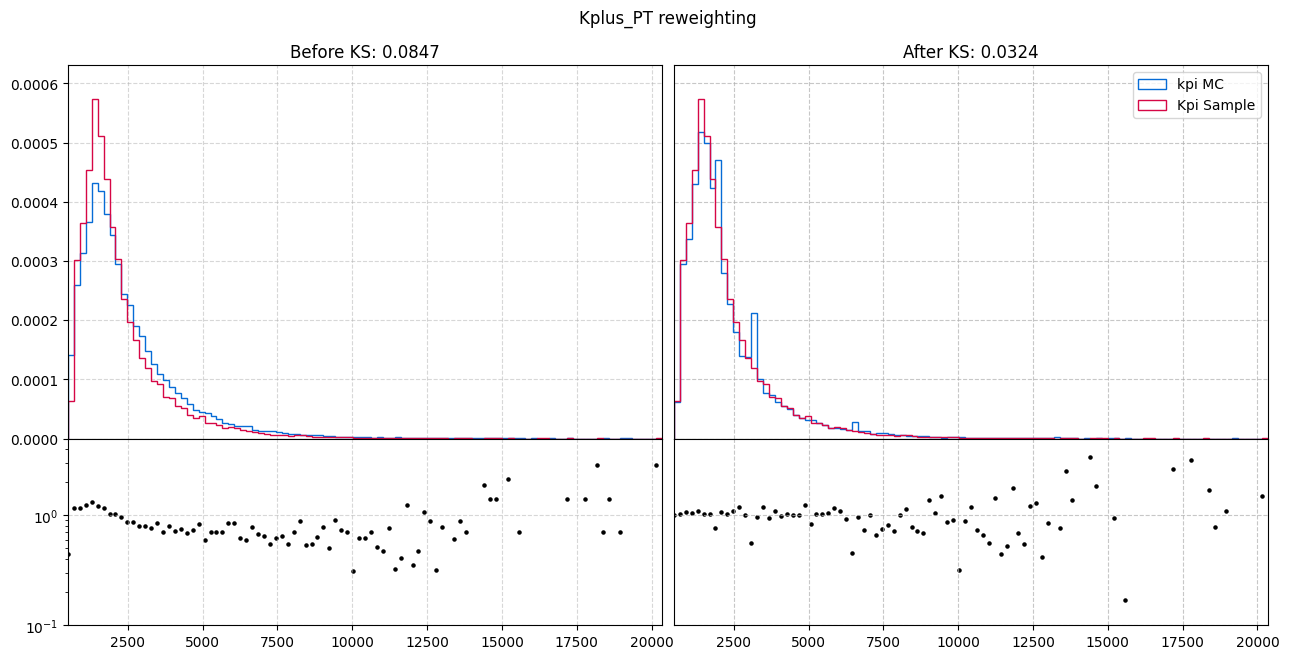

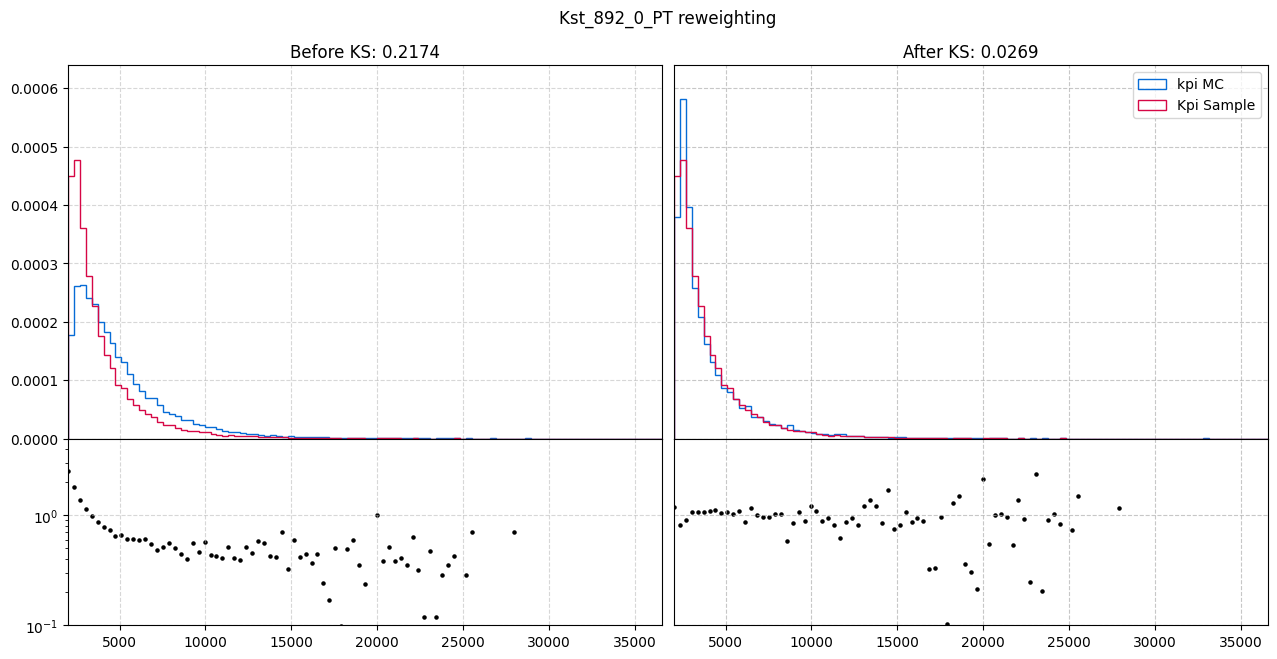

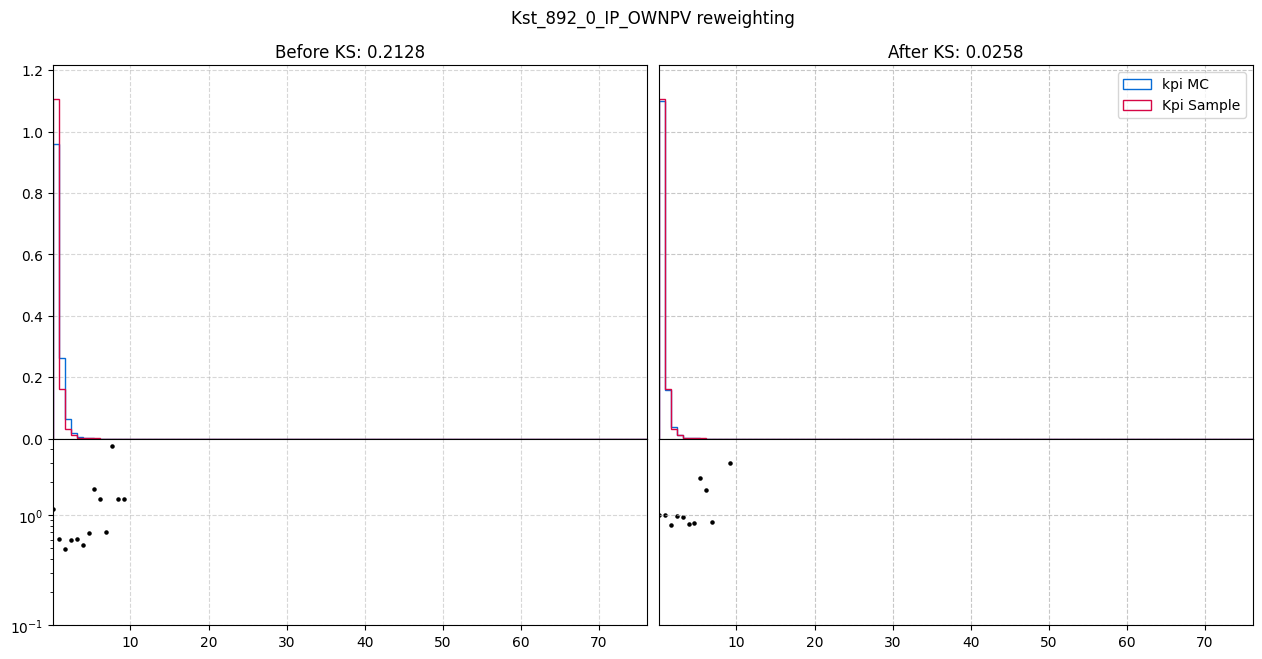

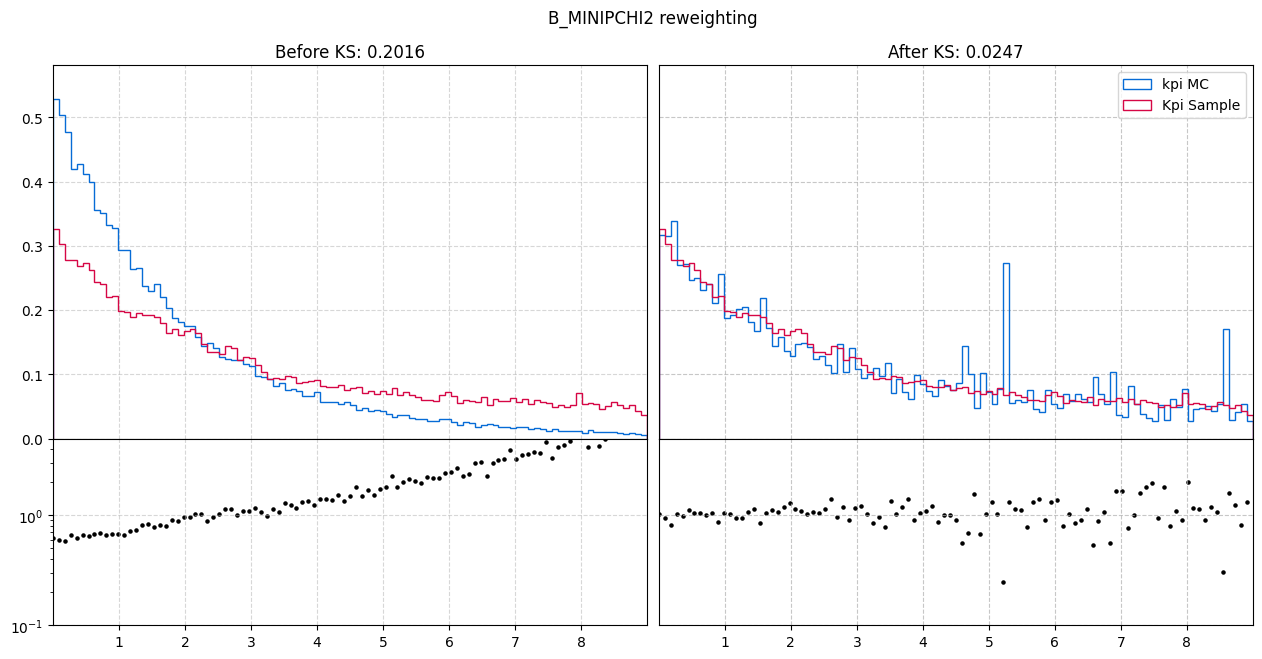

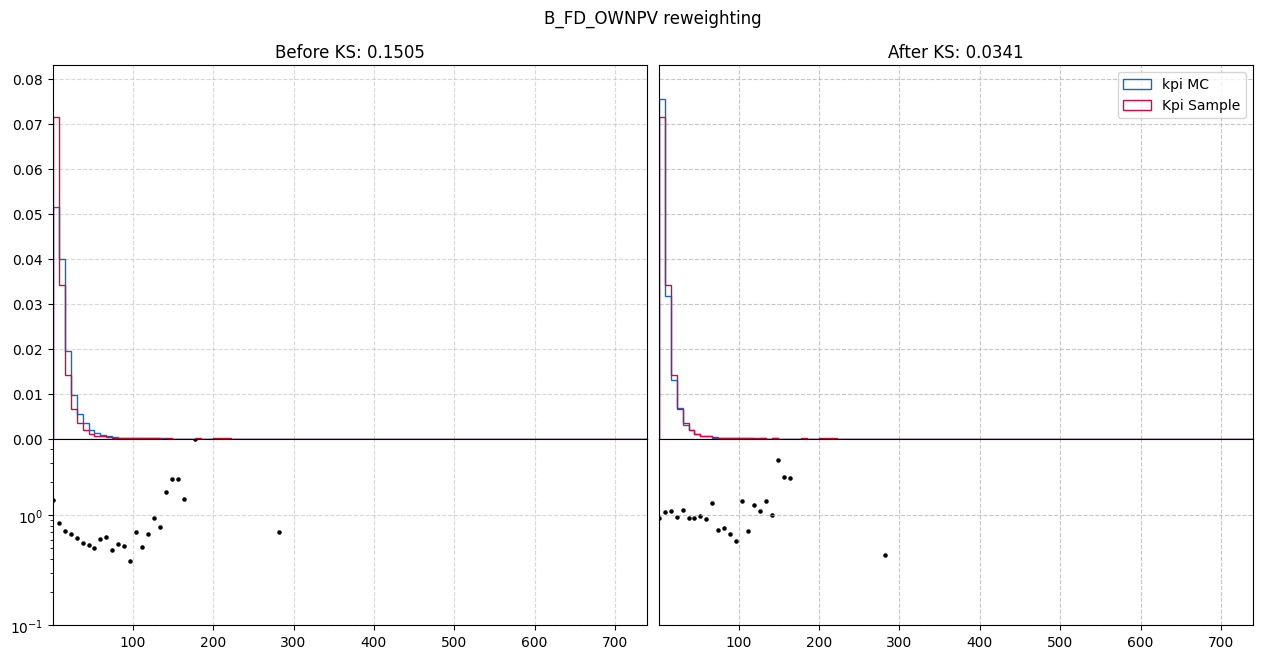

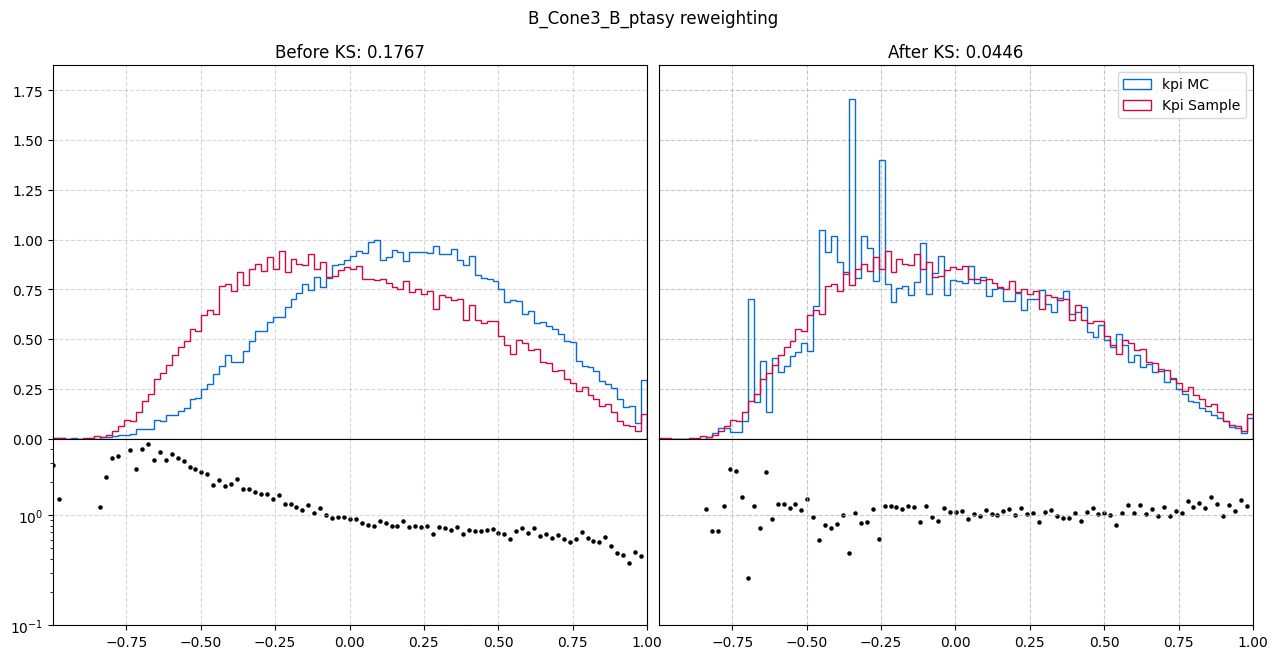

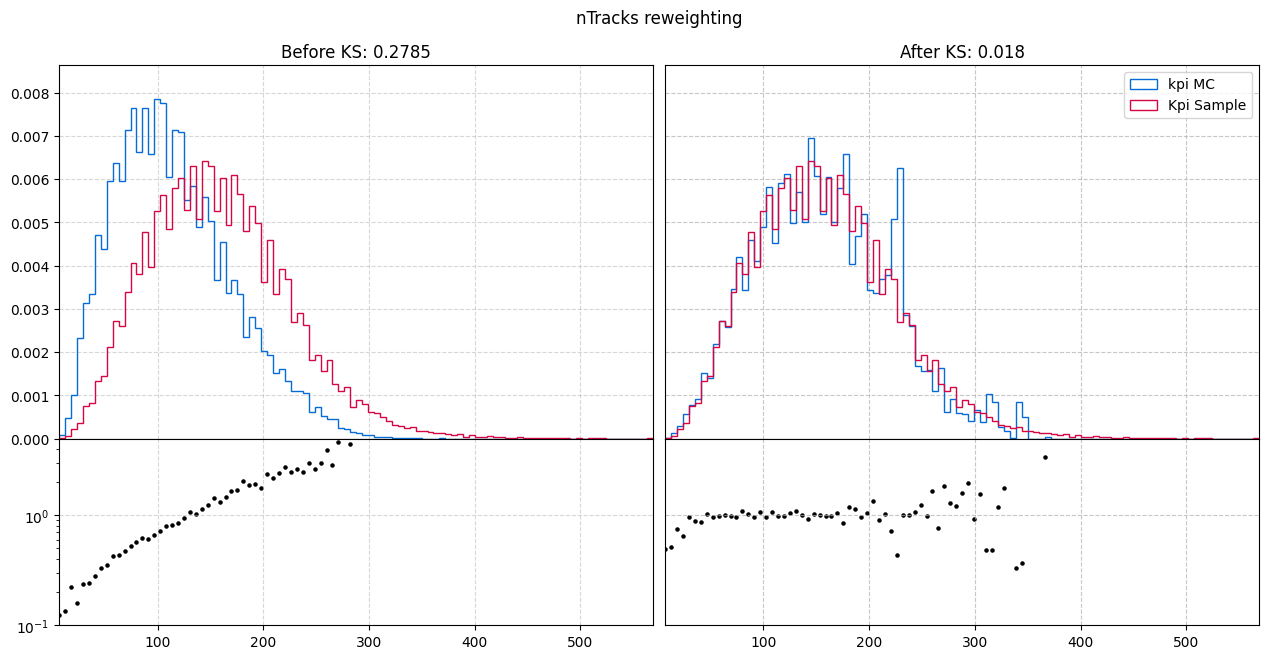

In [137]:

for var in columns:
    CreateDoublePlot(variable=var, Reweighter=GradientBoostedReweighter)